#### Importation bibliothèques et données

In [276]:
#Importation des bibliothèques

import nilearn.datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import seaborn as sns

from nilearn.input_data import NiftiMasker, NiftiMapsMasker, NiftiSpheresMasker, NiftiLabelsMasker
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_connectome

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, auc, roc_curve

In [2]:
#Jeu de données

dataset_abide = nilearn.datasets.fetch_abide_pcp(n_subjects=500)
fmri_filenames = dataset_abide['func_preproc']
dataset_abide.keys()

dict_keys(['description', 'phenotypic', 'func_preproc'])

In [3]:
pheno = pd.DataFrame(dataset_abide['phenotypic'])
pheno.drop(columns = ['i', 'Unnamed: 0'])

,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
1,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,R,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
3,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,L,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
4,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,1,R,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,50957,649,50957,NYU,NYU_0050957,1,1,14.75,2,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,0
496,50958,650,50958,NYU,NYU_0050958,1,1,10.23,2,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,0
497,50959,651,50959,NYU,NYU_0050959,1,2,22.81,2,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,0
498,50960,652,50960,NYU,NYU_0050960,1,2,38.76,2,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,0


In [4]:
y_diagnostic = pheno['DX_GROUP']

In [5]:
y_diagnostic.value_counts()

DX_GROUP
2    258
1    242
Name: count, dtype: int64

#### Visualisation données et phénotype

<Axes: xlabel='SITE_ID', ylabel='count'>

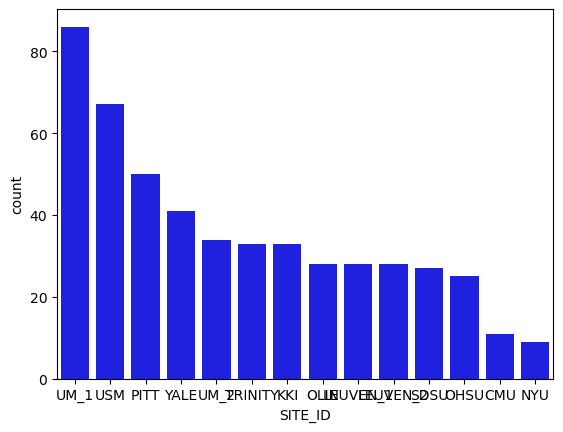

In [11]:
df_site = pd.DataFrame(pheno['SITE_ID'].value_counts()).reset_index()
df_site.columns = ['SITE_ID', 'count']

sns.barplot(x = 'SITE_ID',
            y = 'count',
            data = df_site,
           color = 'blue')

<Axes: xlabel='DX_GROUP', ylabel='AGE_AT_SCAN'>

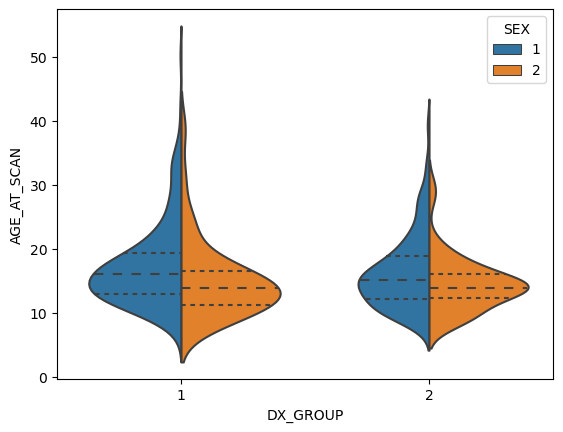

In [13]:
sns.violinplot(data=pheno, x='DX_GROUP', y='AGE_AT_SCAN', hue="SEX", split=True, inner="quart")

#### Application des atlas aux données : HO, Destrieux, Basc197

##### Atlas Harvard Oxford

In [15]:
# Atlas HO
atlas_ho_dataset = nilearn.datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_ho_filepath = atlas_ho_dataset.maps
labels_ho = atlas_ho_dataset.labels

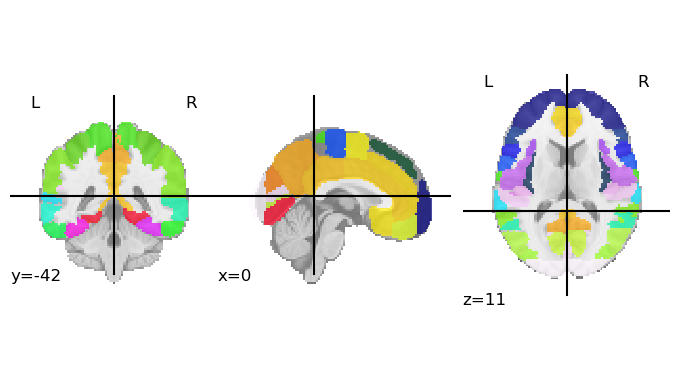

In [17]:
plotting.plot_roi(atlas_ho_dataset.filename, draw_cross=True)

In [18]:
# Application de l'atlas HO aux données

"""
# initialize masker 
masker_ho = NiftiLabelsMasker(labels_img=atlas_ho_dataset.filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# initialize correlation measure, set to vectorize
correlation_measure_ho = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

all_features_corr_ho = []

for i,subj in enumerate(fmri_filenames):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker_ho.fit_transform(subj)
    # create a region x region correlation matrix
    correlation_matrix_ho = correlation_measure_ho.fit_transform([time_series])[0]
    # add to our container
    all_features_corr_ho.append(correlation_matrix_ho)
    # keep track of status
    print('finished %s of %s'%(i+1,len(fmri_filenames)))
    """

"\n# initialize masker \nmasker_ho = NiftiLabelsMasker(labels_img=atlas_ho_dataset.filename, standardize=True, \n                           memory='nilearn_cache', verbose=0)\n\n# initialize correlation measure, set to vectorize\ncorrelation_measure_ho = ConnectivityMeasure(kind='correlation', vectorize=True,\n                                         discard_diagonal=True)\n\nall_features_corr_ho = []\n\nfor i,subj in enumerate(fmri_filenames):\n    # extract the timeseries from the ROIs in the atlas\n    time_series = masker_ho.fit_transform(subj)\n    # create a region x region correlation matrix\n    correlation_matrix_ho = correlation_measure_ho.fit_transform([time_series])[0]\n    # add to our container\n    all_features_corr_ho.append(correlation_matrix_ho)\n    # keep track of status\n    print('finished %s of %s'%(i+1,len(fmri_filenames)))\n    "

In [21]:
#np.savez_compressed('correlation_ho_500patients',a = all_features_corr_ho)

In [23]:
feat_file = 'correlation_ho_500patients.npz'
X_features_corr_ho = np.load(feat_file)['a']

##### Atlas Destrieux

In [25]:
# Atlas Destrieux

atlas_destrieux_dataset = nilearn.datasets.fetch_atlas_destrieux_2009()
atlas_destrieux_filepath = atlas_destrieux_dataset.maps
labels_destrieux = atlas_destrieux_dataset.labels

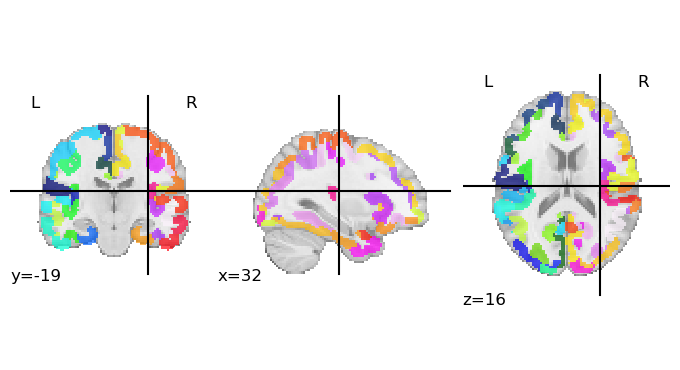

In [27]:
plotting.plot_roi(atlas_destrieux_dataset.maps, draw_cross=True)

In [29]:
# Application de l'atlas Destrieux aux données

"""
# initialize masker
masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux_dataset.maps, standardize=True, 
                           memory='nilearn_cache', verbose=0)
                           
# initialize correlation measure, set to vectorize
correlation_measure_destrieux = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

all_features_corr_destrieux = []

for i,subj in enumerate(fmri_filenames):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker_destrieux.fit_transform(subj)
    # create a region x region correlation matrix
    correlation_matrix_destrieux = correlation_measure_destrieux.fit_transform([time_series])[0]
    # add to our container
    all_features_corr_destrieux.append(correlation_matrix_destrieux)
    # keep track of status
    print('finished %s of %s'%(i+1,len(fmri_filenames)))"""

"\n# initialize masker\nmasker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux_dataset.maps, standardize=True, \n                           memory='nilearn_cache', verbose=0)\n                           \n# initialize correlation measure, set to vectorize\ncorrelation_measure_destrieux = ConnectivityMeasure(kind='correlation', vectorize=True,\n                                         discard_diagonal=True)\n\nall_features_corr_destrieux = []\n\nfor i,subj in enumerate(fmri_filenames):\n    # extract the timeseries from the ROIs in the atlas\n    time_series = masker_destrieux.fit_transform(subj)\n    # create a region x region correlation matrix\n    correlation_matrix_destrieux = correlation_measure_destrieux.fit_transform([time_series])[0]\n    # add to our container\n    all_features_corr_destrieux.append(correlation_matrix_destrieux)\n    # keep track of status\n    print('finished %s of %s'%(i+1,len(fmri_filenames)))"

In [31]:
#np.savez_compressed('correlation_destrieux_500patients',a = all_features_corr_destrieux)

In [33]:
feat_file = 'correlation_destrieux_500patients.npz'
X_features_corr_destrieux = np.load(feat_file)['a']

##### Atlas Basc197

In [168]:
# Atlas BASC197

atlas_basc_dataset = nilearn.datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_basc197_dataset = atlas_basc_dataset.scale197

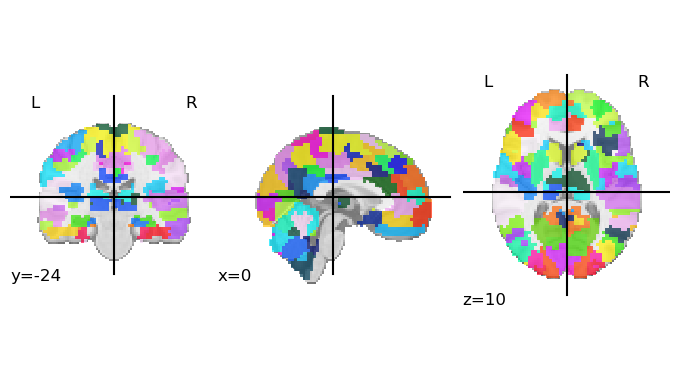

In [170]:
plotting.plot_roi(atlas_basc197_dataset, draw_cross=True)

In [172]:
# Application de l'atlas BASC197 aux données
"""
# initialize masker - à tester
masker_basc197 = NiftiLabelsMasker(labels_img=atlas_basc197_dataset, standardize=True, 
                           memory='nilearn_cache', verbose=0)

# initialize correlation measure, set to vectorize
correlation_measure_basc197 = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

all_features_corr_basc197 = []

for i,subj in enumerate(fmri_filenames):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker_basc197.fit_transform(subj)
    # create a region x region correlation matrix
    correlation_matrix_basc197 = correlation_measure_basc197.fit_transform([time_series])[0]
    # add to our container
    all_features_corr_basc197.append(correlation_matrix_basc197)
    # keep track of status
    print('finished %s of %s'%(i+1,len(fmri_filenames)))"""

finished 1 of 500
finished 2 of 500
finished 3 of 500
finished 4 of 500
finished 5 of 500
finished 6 of 500
finished 7 of 500
finished 8 of 500
finished 9 of 500
finished 10 of 500
finished 11 of 500
finished 12 of 500
finished 13 of 500
finished 14 of 500
finished 15 of 500
finished 16 of 500
finished 17 of 500
finished 18 of 500
finished 19 of 500
finished 20 of 500
finished 21 of 500
finished 22 of 500
finished 23 of 500
finished 24 of 500
finished 25 of 500
finished 26 of 500
finished 27 of 500
finished 28 of 500
finished 29 of 500
finished 30 of 500
finished 31 of 500
finished 32 of 500
finished 33 of 500
finished 34 of 500
finished 35 of 500
finished 36 of 500
finished 37 of 500
finished 38 of 500
finished 39 of 500
finished 40 of 500
finished 41 of 500
finished 42 of 500
finished 43 of 500
finished 44 of 500
finished 45 of 500
finished 46 of 500
finished 47 of 500
finished 48 of 500
finished 49 of 500
finished 50 of 500
finished 51 of 500
finished 52 of 500
finished 53 of 500
fi

In [174]:
np.savez_compressed('correlation_basc197_500patients',a = all_features_corr_basc197)

In [176]:
feat_file = 'correlation_basc197_500patients.npz'
X_features_corr_basc197 = np.load(feat_file)['a']

#### Premier test machine learning : Corrélation - HO - KNN sur 500 sujets

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_features_corr_ho,
                                                    y_diagnostic,
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    stratify = y_diagnostic,
                                                    random_state = 123)

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_test))

print("Train", y_train.value_counts())
print("Test", y_test.value_counts())

training: 375 testing: 125
Train DX_GROUP
2    194
1    181
Name: count, dtype: int64
Test DX_GROUP
2    64
1    61
Name: count, dtype: int64


In [39]:
# KNN1 : Cross validation 10 folds

knn1 = KNeighborsClassifier(n_neighbors=1)
cv = StratifiedKFold(n_splits=10)
y_pred_corr_ho_knn1 = cross_val_predict(knn1, X_train, y_train, cv = cv)

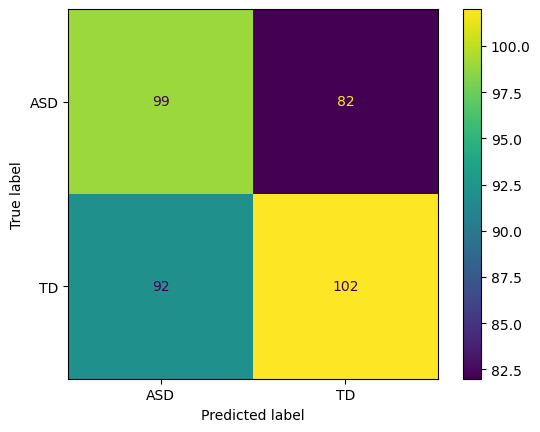

In [41]:
# Matrice de confusion

conf_matrix_corr_ho_knn1 = confusion_matrix(y_train, y_pred_corr_ho_knn1)

disp = ConfusionMatrixDisplay(conf_matrix_corr_ho_knn1, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [43]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_ho_knn1 = accuracy_score(y_train, y_pred_corr_ho_knn1)
print("Accuracy : ", round(accuracy_corr_ho_knn1,3))

# Calcul de la sensitivité
sensitivity_corr_ho_knn1 = conf_matrix_corr_ho_knn1[1,1] / (conf_matrix_corr_ho_knn1[1,0] + conf_matrix_corr_ho_knn1[1,1])
print("Sensitivité : ", round(sensitivity_corr_ho_knn1,3))

# Calcul de la spécificité
specificity_corr_ho_knn1 = conf_matrix_corr_ho_knn1[0,0] / (conf_matrix_corr_ho_knn1[0,0] + conf_matrix_corr_ho_knn1[0,1])
print("Spécificité : ", round(specificity_corr_ho_knn1,3))

# Calcul du classification report
class_report_corr_ho_knn1 = classification_report(y_train, y_pred_corr_ho_knn1)
print("Classification Report :\n", class_report_corr_ho_knn1)

Accuracy :  0.536
Sensitivité :  0.526
Spécificité :  0.547
Classification Report :
               precision    recall  f1-score   support

           1       0.52      0.55      0.53       181
           2       0.55      0.53      0.54       194

    accuracy                           0.54       375
   macro avg       0.54      0.54      0.54       375
weighted avg       0.54      0.54      0.54       375



In [ ]:
#Affichage de courbe ROC

#### ML : 500 sujets - Corrélation - Atlas HO - LR/GNB/kSVM/RF/GradientBoosting

##### Création base d'entraînement et base de test

In [234]:
X_train_ho, X_test_ho, y_train_ho, y_test_ho = train_test_split(X_features_corr_ho,
                                                    y_diagnostic,
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    stratify = y_diagnostic,
                                                    random_state = 123)

# print the size of our training and test groups
print('training:', len(X_train_ho),
     'testing:', len(X_test_ho))

print("Train :", y_train_ho.value_counts())
print("Test", y_test_ho.value_counts())

training: 375 testing: 125
Train : DX_GROUP
2    194
1    181
Name: count, dtype: int64
Test DX_GROUP
2    64
1    61
Name: count, dtype: int64


##### Régression Logistique

In [236]:
# Optimisation hyperparamètres

param_grid_LR = {'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']}

LR_opt = LogisticRegression()
grid_search_LR = GridSearchCV(LR_opt, param_grid_LR, cv=5, scoring='accuracy')
grid_search_LR.fit(X_train_ho, y_train_ho)

print("Best parameters for Logistic Regression:", grid_search_LR.best_params_)

C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2'}


In [237]:
#LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)[source]

#LR : Cross validation 10 folds

LR_corr_ho = LogisticRegression(C = 0.01, penalty='l2')
cv = StratifiedKFold(n_splits=10)
y_pred_corr_ho_lr = cross_val_predict(LR_corr_ho, X_train_ho, y_train_ho, cv = cv)

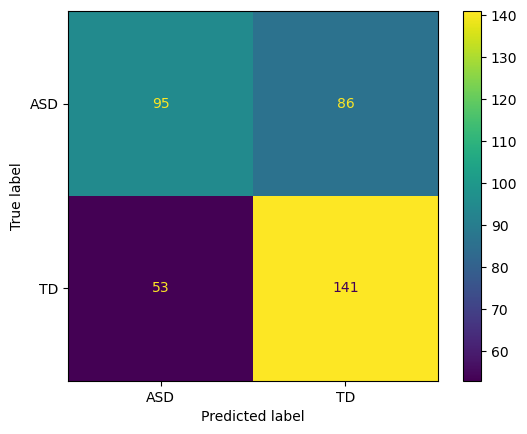

In [238]:
# Matrice de confusion

conf_matrix_corr_ho_lr = confusion_matrix(y_train_ho, y_pred_corr_ho_lr)

disp = ConfusionMatrixDisplay(conf_matrix_corr_ho_lr, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [239]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_ho_lr = accuracy_score(y_train_ho, y_pred_corr_ho_lr)
print("Accuracy : ", round(accuracy_corr_ho_lr,3))

# Calcul de la sensitivité
sensitivity_corr_ho_lr = conf_matrix_corr_ho_lr[1,1] / (conf_matrix_corr_ho_lr[1,0] + conf_matrix_corr_ho_lr[1,1])
print("Sensitivité : ", round(sensitivity_corr_ho_lr,3))

# Calcul de la spécificité
specificity_corr_ho_lr = conf_matrix_corr_ho_lr[0,0] / (conf_matrix_corr_ho_lr[0,0] + conf_matrix_corr_ho_lr[0,1])
print("Spécificité : ", round(specificity_corr_ho_lr,3))

# Calcul du classification report
class_report_corr_ho_lr = classification_report(y_train_ho, y_pred_corr_ho_lr)
print("Classification Report :\n", class_report_corr_ho_lr)

Accuracy :  0.629
Sensitivité :  0.727
Spécificité :  0.525
Classification Report :
               precision    recall  f1-score   support

           1       0.64      0.52      0.58       181
           2       0.62      0.73      0.67       194

    accuracy                           0.63       375
   macro avg       0.63      0.63      0.62       375
weighted avg       0.63      0.63      0.63       375



##### Classfieur Gaussien Naïf de Bayes

In [244]:
#sklearn.naive_bayes.GaussianNB(*, priors=None, var_smoothing=1e-09)

#GNB: Cross validation 10 folds

GNB_corr_ho = GaussianNB()
cv = StratifiedKFold(n_splits=10)
y_pred_corr_ho_gnb = cross_val_predict(GNB_corr_ho, X_train_ho, y_train_ho, cv = cv)

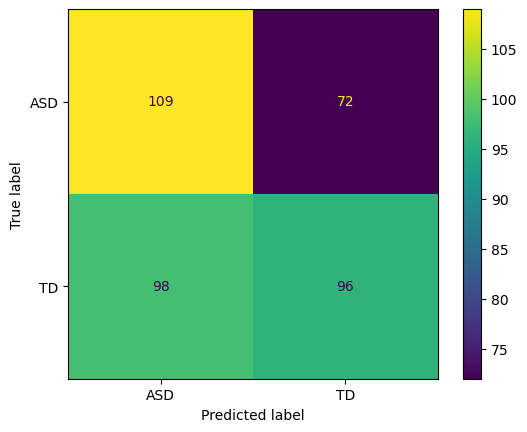

In [246]:
# Matrice de confusion

conf_matrix_corr_ho_gnb = confusion_matrix(y_train_ho, y_pred_corr_ho_gnb)

disp = ConfusionMatrixDisplay(conf_matrix_corr_ho_gnb, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [248]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_ho_gnb = accuracy_score(y_train_ho, y_pred_corr_ho_gnb)
print("Accuracy : ", round(accuracy_corr_ho_gnb,3))

# Calcul de la sensitivité
sensitivity_corr_ho_gnb = conf_matrix_corr_ho_gnb[1,1] / (conf_matrix_corr_ho_gnb[1,0] + conf_matrix_corr_ho_gnb[1,1])
print("Sensitivité : ", round(sensitivity_corr_ho_gnb,3))

# Calcul de la spécificité
specificity_corr_ho_gnb = conf_matrix_corr_ho_gnb[0,0] / (conf_matrix_corr_ho_gnb[0,0] + conf_matrix_corr_ho_gnb[0,1])
print("Spécificité : ", round(specificity_corr_ho_gnb,3))

# Calcul du classification report
class_report_corr_ho_gnb = classification_report(y_train_ho, y_pred_corr_ho_gnb)
print("Classification Report :\n", class_report_corr_ho_gnb)

Accuracy :  0.547
Sensitivité :  0.495
Spécificité :  0.602
Classification Report :
               precision    recall  f1-score   support

           1       0.53      0.60      0.56       181
           2       0.57      0.49      0.53       194

    accuracy                           0.55       375
   macro avg       0.55      0.55      0.55       375
weighted avg       0.55      0.55      0.55       375



##### Kernel SVM

In [251]:
# Optimisation hyperparamètres

param_grid_SVM = {'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf','sigmoid'],
    'degree' : [2,3,4,5]}

SVM_opt = SVC()
grid_search_SVM = GridSearchCV(SVM_opt, param_grid_SVM, cv=5, scoring='accuracy')
grid_search_SVM.fit(X_train_ho, y_train_ho)

print("Best parameters for Logistic Regression:", grid_search_SVM.best_params_)

Best parameters for Logistic Regression: {'C': 1, 'degree': 2, 'kernel': 'poly'}


In [252]:
#sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

# SVM : Cross-validation 10 folds
svm = SVC (kernel = 'poly', C=1, degree = 2)
cv = StratifiedKFold(n_splits=10)
y_pred_corr_ho_svm = cross_val_predict(svm, X_train_ho, y_train_ho, cv = cv)

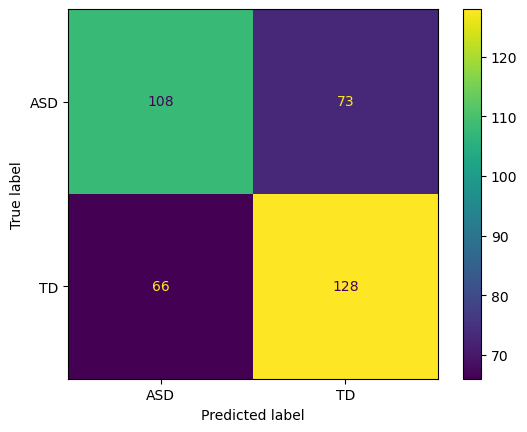

In [253]:
# Matrice de confusion

conf_matrix_corr_ho_svm = confusion_matrix(y_train_ho, y_pred_corr_ho_svm)

disp = ConfusionMatrixDisplay(conf_matrix_corr_ho_svm, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [254]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_ho_svm = accuracy_score(y_train_ho, y_pred_corr_ho_svm)
print("Accuracy : ", round(accuracy_corr_ho_svm,3))

# Calcul de la sensitivité
sensitivity_corr_ho_svm = conf_matrix_corr_ho_svm[1,1] / (conf_matrix_corr_ho_svm[1,0] + conf_matrix_corr_ho_svm[1,1])
print("Sensitivité : ", round(sensitivity_corr_ho_svm,3))

# Calcul de la spécificité
specificity_corr_ho_svm = conf_matrix_corr_ho_svm[0,0] / (conf_matrix_corr_ho_svm[0,0] + conf_matrix_corr_ho_svm[0,1])
print("Spécificité : ", round(specificity_corr_ho_svm,3))

# Calcul du classification report
class_report_corr_ho_svm = classification_report(y_train_ho, y_pred_corr_ho_svm)
print("Classification Report :\n", class_report_corr_ho_svm)

Accuracy :  0.629
Sensitivité :  0.66
Spécificité :  0.597
Classification Report :
               precision    recall  f1-score   support

           1       0.62      0.60      0.61       181
           2       0.64      0.66      0.65       194

    accuracy                           0.63       375
   macro avg       0.63      0.63      0.63       375
weighted avg       0.63      0.63      0.63       375



##### Random Forest

In [256]:
# Optimisation hyperparamètres

param_grid_RF = {'n_estimators': [100, 200, 300],
                'max_depth': [5,10,20],
                'criterion' : ['gini','entropy','log_loss']}

RF_opt = RandomForestClassifier()
grid_search_RF = GridSearchCV(RF_opt, param_grid_RF, cv=5, scoring='accuracy')
grid_search_RF.fit(X_train_ho, y_train_ho)

print("Best parameters for Logistic Regression:", grid_search_RF.best_params_)

Best parameters for Logistic Regression: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}


In [257]:
#class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

RF = RandomForestClassifier(n_estimators=100, criterion ='log_loss', max_depth=10, random_state=123)
cv = StratifiedKFold(n_splits=10)
y_pred_corr_ho_rf = cross_val_predict(RF, X_train_ho, y_train_ho, cv = cv)

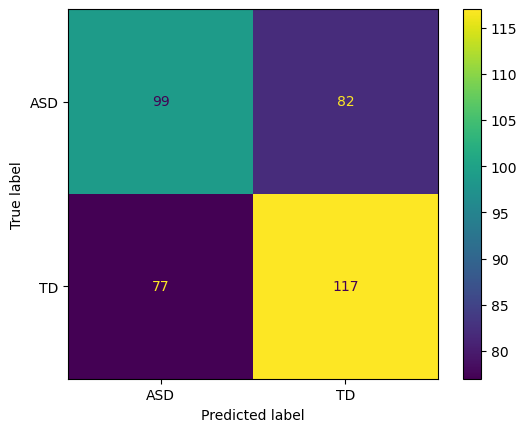

In [258]:
# Matrice de confusion

conf_matrix_corr_ho_rf = confusion_matrix(y_train_ho, y_pred_corr_ho_rf)

disp = ConfusionMatrixDisplay(conf_matrix_corr_ho_rf, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [259]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_ho_rf = accuracy_score(y_train_ho, y_pred_corr_ho_rf)
print("Accuracy : ", round(accuracy_corr_ho_rf,3))

# Calcul de la sensitivité
sensitivity_corr_ho_rf = conf_matrix_corr_ho_rf[1,1] / (conf_matrix_corr_ho_rf[1,0] + conf_matrix_corr_ho_rf[1,1])
print("Sensitivité : ", round(sensitivity_corr_ho_rf,3))

# Calcul de la spécificité
specificity_corr_ho_rf = conf_matrix_corr_ho_rf[0,0] / (conf_matrix_corr_ho_rf[0,0] + conf_matrix_corr_ho_rf[0,1])
print("Spécificité : ", round(specificity_corr_ho_rf,3))

# Calcul du classification report
class_report_corr_ho_rf = classification_report(y_train_ho, y_pred_corr_ho_rf)
print("Classification Report :\n", class_report_corr_ho_rf)

Accuracy :  0.576
Sensitivité :  0.603
Spécificité :  0.547
Classification Report :
               precision    recall  f1-score   support

           1       0.56      0.55      0.55       181
           2       0.59      0.60      0.60       194

    accuracy                           0.58       375
   macro avg       0.58      0.58      0.58       375
weighted avg       0.58      0.58      0.58       375



##### Gradient Boosting - Avec sklearn prend trop de temps

In [353]:
#pip install xgboost


   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 991.0 kB/s eta 0:01:41
   ---------------------------------------- 0.3/99.8 MB 2.8 MB/s eta 0:00:37
   ---------------------------------------- 0.5/99.8 MB 3.7 MB/s eta 0:00:27
   ---------------------------------------- 0.8/99.8 MB 4.2 MB/s eta 0:00:24
   ---------------------------------------- 1.0/99.8 MB 4.4 MB/s eta 0:00:23
    --------------------------------------- 1.4/99.8 MB 5.0 MB/s eta 0:00:20
    --------------------------------------- 1.6/99.8 MB 5.3 MB/s eta 0:00:19
    --------------------------------------- 1.6/99.8 MB 4.3 MB/s eta 0:00:23
    --------------------------------------- 1.8/99.8 MB 4.3 MB/s eta 0:00:23
    --------------------------------------- 1.9/99.8 MB 4.2 MB/s eta 0:00:24
    --------------------------------------- 2.0/99.8 MB 4.0 MB/s eta 0:00:25
    ------

In [349]:
#sklearn.ensemble.GradientBoostingClassifier(*, loss='log_loss', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
#prend trop de temps

# Gradient Boosting : cross validation 10 folds

GB = GradientBoostingClassifier()
cv = StratifiedKFold(n_splits=10)
y_pred_corr_ho_gb = cross_val_predict(GB, X_train_ho, y_train_ho, cv = cv)

KeyboardInterrupt: 

In [ ]:
# Matrice de confusion

conf_matrix_corr_ho_gb = confusion_matrix(y_train_ho, y_pred_corr_ho_gb)

disp = ConfusionMatrixDisplay(conf_matrix_corr_ho_gb, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [ ]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_ho_gb = accuracy_score(y_train_ho, y_pred_corr_ho_gb)
print("Accuracy : ", round(accuracy_corr_ho_gb,3))

# Calcul de la sensitivité
sensitivity_corr_ho_gb = conf_matrix_corr_ho_gb[1,1] / (conf_matrix_corr_ho_gb[1,0] + conf_matrix_corr_ho_gb[1,1])
print("Sensitivité : ", round(sensitivity_corr_ho_gb,3))

# Calcul de la spécificité
specificity_corr_ho_gb = conf_matrix_corr_ho_gb[0,0] / (conf_matrix_corr_ho_gb[0,0] + conf_matrix_corr_ho_gb[0,1])
print("Spécificité : ", round(specificity_corr_ho_gb,3))

# Calcul du classification report
class_report_corr_ho_gb = classification_report(y_train_ho, y_pred_corr_ho_gb)
print("Classification Report :\n", class_report_corr_ho_gb)

#### ML : 500 sujets - Corrélation - Atlas Destrieux - LR/GNB/kSVM/RF

##### Création base d'entraînement et base de test

In [264]:
X_train_destrieux, X_test_destrieux, y_train_destrieux, y_test_destrieux = train_test_split(X_features_corr_destrieux,
                                                    y_diagnostic,
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    stratify = y_diagnostic,
                                                    random_state = 123)

# print the size of our training and test groups
print('training:', len(X_train_destrieux),
     'testing:', len(X_test_destrieux))

print("Train :", y_train_destrieux.value_counts())
print("Test", y_test_destrieux.value_counts())

training: 375 testing: 125
Train : DX_GROUP
2    194
1    181
Name: count, dtype: int64
Test DX_GROUP
2    64
1    61
Name: count, dtype: int64


##### Régression logistique

In [83]:
# Optimisation hyperparamètres

param_grid_LR = {'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']}

LR_opt = LogisticRegression()
grid_search_LR = GridSearchCV(LR_opt, param_grid_LR, cv=5, scoring='accuracy')
grid_search_LR.fit(X_train_destrieux, y_train_destrieux)

print("Best parameters for Logistic Regression:", grid_search_LR.best_params_)

C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}


C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [85]:
#LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)[source]

#LR : Cross validation 10 folds

LR_corr_destrieux = LogisticRegression(C = 1, penalty='l2')
cv = StratifiedKFold(n_splits=10)
y_pred_corr_destrieux_lr = cross_val_predict(LR_corr_destrieux, X_train_destrieux, y_train_destrieux, cv = cv)

C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

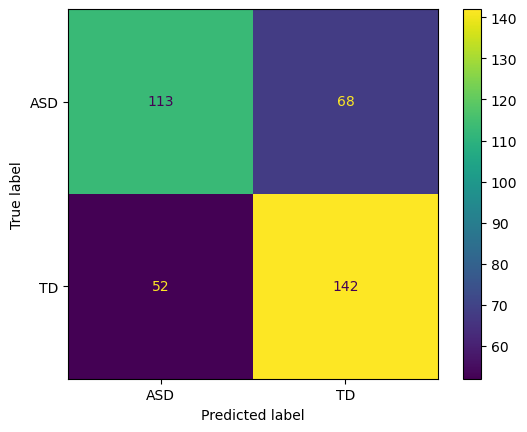

In [87]:
# Matrice de confusion

conf_matrix_corr_destrieux_lr = confusion_matrix(y_train_destrieux, y_pred_corr_destrieux_lr)

disp = ConfusionMatrixDisplay(conf_matrix_corr_destrieux_lr, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [89]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_destrieux_lr = accuracy_score(y_train_destrieux, y_pred_corr_destrieux_lr)
print("Accuracy : ", round(accuracy_corr_destrieux_lr,3))

# Calcul de la sensitivité
sensitivity_corr_destrieux_lr = conf_matrix_corr_destrieux_lr[1,1] / (conf_matrix_corr_destrieux_lr[1,0] + conf_matrix_corr_destrieux_lr[1,1])
print("Sensitivité : ", round(sensitivity_corr_destrieux_lr,3))

# Calcul de la spécificité
specificity_corr_destrieux_lr = conf_matrix_corr_destrieux_lr[0,0] / (conf_matrix_corr_destrieux_lr[0,0] + conf_matrix_corr_destrieux_lr[0,1])
print("Spécificité : ", round(specificity_corr_destrieux_lr,3))

# Calcul du classification report
class_report_corr_destrieux_lr = classification_report(y_train_destrieux, y_pred_corr_destrieux_lr)
print("Classification Report :\n", class_report_corr_destrieux_lr)

Accuracy :  0.68
Sensitivité :  0.732
Spécificité :  0.624
Classification Report :
               precision    recall  f1-score   support

           1       0.68      0.62      0.65       181
           2       0.68      0.73      0.70       194

    accuracy                           0.68       375
   macro avg       0.68      0.68      0.68       375
weighted avg       0.68      0.68      0.68       375



##### Classifieur Gaussien Naïf de Bayes

In [91]:
#sklearn.naive_bayes.GaussianNB(*, priors=None, var_smoothing=1e-09)

#GNB: Cross validation 10 folds

GNB_corr_destrieux = GaussianNB()
cv = StratifiedKFold(n_splits=10)
y_pred_corr_destrieux_gnb = cross_val_predict(GNB_corr_destrieux, X_train_destrieux, y_train_destrieux, cv = cv)

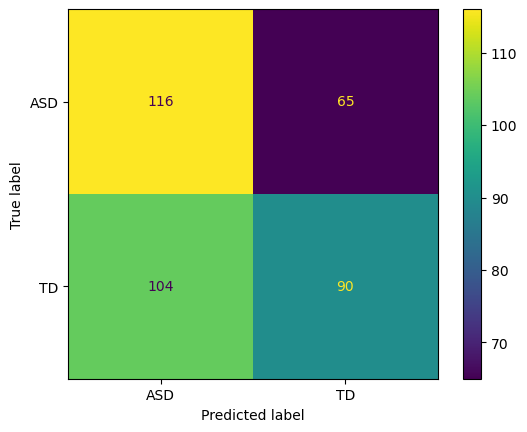

In [93]:
# Matrice de confusion

conf_matrix_corr_destrieux_gnb = confusion_matrix(y_train_destrieux, y_pred_corr_destrieux_gnb)

disp = ConfusionMatrixDisplay(conf_matrix_corr_destrieux_gnb, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [95]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_destrieux_gnb = accuracy_score(y_train_destrieux, y_pred_corr_destrieux_gnb)
print("Accuracy : ", round(accuracy_corr_destrieux_gnb,3))

# Calcul de la sensitivité
sensitivity_corr_destrieux_gnb = conf_matrix_corr_destrieux_gnb[1,1] / (conf_matrix_corr_destrieux_gnb[1,0] + conf_matrix_corr_destrieux_gnb[1,1])
print("Sensitivité : ", round(sensitivity_corr_destrieux_gnb,3))

# Calcul de la spécificité
specificity_corr_destrieux_gnb = conf_matrix_corr_destrieux_gnb[0,0] / (conf_matrix_corr_destrieux_gnb[0,0] + conf_matrix_corr_destrieux_gnb[0,1])
print("Spécificité : ", round(specificity_corr_destrieux_gnb,3))

# Calcul du classification report
class_report_corr_destrieux_gnb = classification_report(y_train_destrieux, y_pred_corr_destrieux_gnb)
print("Classification Report :\n", class_report_corr_destrieux_gnb)

Accuracy :  0.549
Sensitivité :  0.464
Spécificité :  0.641
Classification Report :
               precision    recall  f1-score   support

           1       0.53      0.64      0.58       181
           2       0.58      0.46      0.52       194

    accuracy                           0.55       375
   macro avg       0.55      0.55      0.55       375
weighted avg       0.55      0.55      0.55       375



##### Kernel SVM

In [97]:
# Optimisation hyperparamètres

param_grid_SVM = {'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf','sigmoid'],
    'degree' : [2,3,4,5]}

SVM_opt = SVC()
grid_search_SVM = GridSearchCV(SVM_opt, param_grid_SVM, cv=5, scoring='accuracy')
grid_search_SVM.fit(X_train_destrieux, y_train_destrieux)

print("Best parameters for Logistic Regression:", grid_search_SVM.best_params_)

Best parameters for Logistic Regression: {'C': 0.1, 'degree': 2, 'kernel': 'linear'}


In [99]:
#sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

# SVM : Cross-validation 10 folds
svm = SVC (kernel = 'linear', C=0.1)
cv = StratifiedKFold(n_splits=10)
y_pred_corr_destrieux_svm = cross_val_predict(svm, X_train_destrieux, y_train_destrieux, cv = cv)

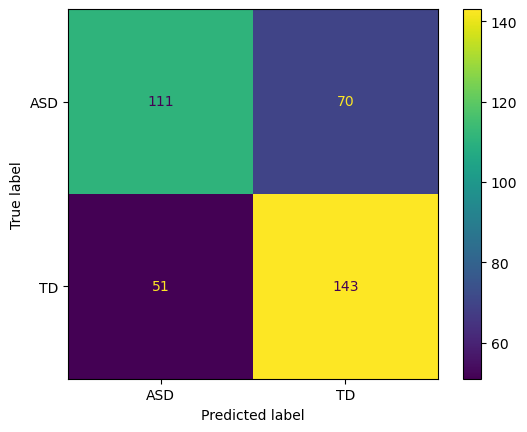

In [101]:
# Matrice de confusion

conf_matrix_corr_destrieux_svm = confusion_matrix(y_train_destrieux, y_pred_corr_destrieux_svm)

disp = ConfusionMatrixDisplay(conf_matrix_corr_destrieux_svm, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [103]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_destrieux_svm = accuracy_score(y_train_destrieux, y_pred_corr_destrieux_svm)
print("Accuracy : ", round(accuracy_corr_destrieux_svm,3))

# Calcul de la sensitivité
sensitivity_corr_destrieux_svm = conf_matrix_corr_destrieux_svm[1,1] / (conf_matrix_corr_destrieux_svm[1,0] + conf_matrix_corr_destrieux_svm[1,1])
print("Sensitivité : ", round(sensitivity_corr_destrieux_svm,3))

# Calcul de la spécificité
specificity_corr_destrieux_svm = conf_matrix_corr_destrieux_svm[0,0] / (conf_matrix_corr_destrieux_svm[0,0] + conf_matrix_corr_destrieux_svm[0,1])
print("Spécificité : ", round(specificity_corr_destrieux_svm,3))

# Calcul du classification report
class_report_corr_destrieux_svm = classification_report(y_train_destrieux, y_pred_corr_destrieux_svm)
print("Classification Report :\n", class_report_corr_destrieux_svm)

Accuracy :  0.677
Sensitivité :  0.737
Spécificité :  0.613
Classification Report :
               precision    recall  f1-score   support

           1       0.69      0.61      0.65       181
           2       0.67      0.74      0.70       194

    accuracy                           0.68       375
   macro avg       0.68      0.68      0.67       375
weighted avg       0.68      0.68      0.68       375



##### Random Forest

In [105]:
# Optimisation hyperparamètres

param_grid_RF = {'n_estimators': [100, 200, 300],
                'max_depth': [5,10,20],
                'criterion' : ['gini','entropy','log_loss']}

RF_opt = RandomForestClassifier()
grid_search_RF = GridSearchCV(RF_opt, param_grid_RF, cv=5, scoring='accuracy')
grid_search_RF.fit(X_train_destrieux, y_train_destrieux)

print("Best parameters for Logistic Regression:", grid_search_RF.best_params_)

Best parameters for Logistic Regression: {'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 200}


In [113]:
#class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

RF = RandomForestClassifier(n_estimators=200, criterion ='log_loss', max_depth=10, random_state=123)
cv = StratifiedKFold(n_splits=10)
y_pred_corr_destrieux_rf = cross_val_predict(RF, X_train_destrieux, y_train_destrieux, cv = cv)

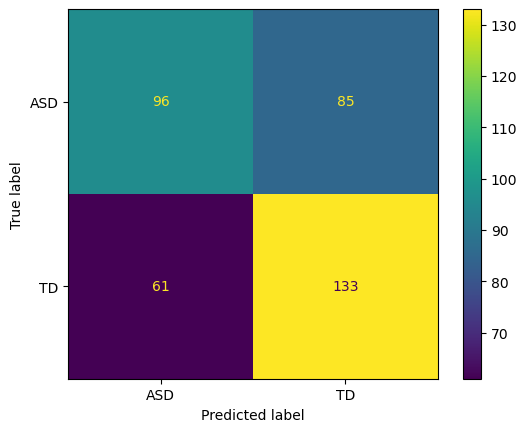

In [115]:
# Matrice de confusion

conf_matrix_corr_destrieux_rf = confusion_matrix(y_train_destrieux, y_pred_corr_destrieux_rf)

disp = ConfusionMatrixDisplay(conf_matrix_corr_destrieux_rf, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [117]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_destrieux_rf = accuracy_score(y_train_destrieux, y_pred_corr_destrieux_rf)
print("Accuracy : ", round(accuracy_corr_destrieux_rf,3))

# Calcul de la sensitivité
sensitivity_corr_destrieux_rf = conf_matrix_corr_destrieux_rf[1,1] / (conf_matrix_corr_destrieux_rf[1,0] + conf_matrix_corr_destrieux_rf[1,1])
print("Sensitivité : ", round(sensitivity_corr_destrieux_rf,3))

# Calcul de la spécificité
specificity_corr_destrieux_rf = conf_matrix_corr_destrieux_rf[0,0] / (conf_matrix_corr_destrieux_rf[0,0] + conf_matrix_corr_destrieux_rf[0,1])
print("Spécificité : ", round(specificity_corr_destrieux_rf,3))

# Calcul du classification report
class_report_corr_destrieux_rf = classification_report(y_train_destrieux, y_pred_corr_destrieux_rf)
print("Classification Report :\n", class_report_corr_destrieux_rf)

Accuracy :  0.611
Sensitivité :  0.686
Spécificité :  0.53
Classification Report :
               precision    recall  f1-score   support

           1       0.61      0.53      0.57       181
           2       0.61      0.69      0.65       194

    accuracy                           0.61       375
   macro avg       0.61      0.61      0.61       375
weighted avg       0.61      0.61      0.61       375



#### ML : 500 sujets - Corrélation - Atlas BASC197 - LR/GNB/kSVM/RF

##### Création base d'entraînement et de test

In [265]:
X_train_basc197, X_test_basc197, y_train_basc197, y_test_basc197 = train_test_split(X_features_corr_basc197,
                                                    y_diagnostic,
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    stratify = y_diagnostic,
                                                    random_state = 123)

# print the size of our training and test groups
print('training:', len(X_train_basc197),
     'testing:', len(X_test_basc197))

print("Train :", y_train_basc197.value_counts())
print("Test", y_test_basc197.value_counts())

training: 375 testing: 125
Train : DX_GROUP
2    194
1    181
Name: count, dtype: int64
Test DX_GROUP
2    64
1    61
Name: count, dtype: int64


##### Régression logistique

In [180]:
# Optimisation hyperparamètres

param_grid_LR = {'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']}

LR_opt = LogisticRegression()
grid_search_LR = GridSearchCV(LR_opt, param_grid_LR, cv=5, scoring='accuracy')
grid_search_LR.fit(X_train_basc197, y_train_basc197)

print("Best parameters for Logistic Regression:", grid_search_LR.best_params_)

C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}


C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [184]:
#LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)[source]

#LR : Cross validation 10 folds

LR_corr_basc197 = LogisticRegression(C = 0.1, penalty='l2')
cv = StratifiedKFold(n_splits=10)
y_pred_corr_basc197_lr = cross_val_predict(LR_corr_basc197, X_train_basc197, y_train_basc197, cv = cv)

C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

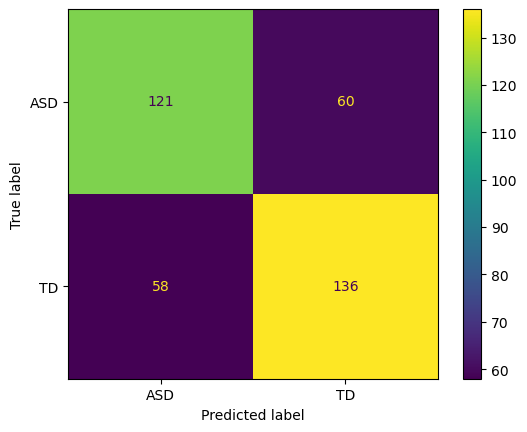

In [186]:
# Matrice de confusion

conf_matrix_corr_basc197_lr = confusion_matrix(y_train_basc197, y_pred_corr_basc197_lr)

disp = ConfusionMatrixDisplay(conf_matrix_corr_basc197_lr, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [188]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_basc197_lr = accuracy_score(y_train_basc197, y_pred_corr_basc197_lr)
print("Accuracy : ", round(accuracy_corr_basc197_lr,3))

# Calcul de la sensitivité
sensitivity_corr_basc197_lr = conf_matrix_corr_basc197_lr[1,1] / (conf_matrix_corr_basc197_lr[1,0] + conf_matrix_corr_basc197_lr[1,1])
print("Sensitivité : ", round(sensitivity_corr_basc197_lr,3))

# Calcul de la spécificité
specificity_corr_basc197_lr = conf_matrix_corr_basc197_lr[0,0] / (conf_matrix_corr_basc197_lr[0,0] + conf_matrix_corr_basc197_lr[0,1])
print("Spécificité : ", round(specificity_corr_basc197_lr,3))

# Calcul du classification report
class_report_corr_basc197_lr = classification_report(y_train_basc197, y_pred_corr_basc197_lr)
print("Classification Report :\n", class_report_corr_basc197_lr)

Accuracy :  0.685
Sensitivité :  0.701
Spécificité :  0.669
Classification Report :
               precision    recall  f1-score   support

           1       0.68      0.67      0.67       181
           2       0.69      0.70      0.70       194

    accuracy                           0.69       375
   macro avg       0.68      0.68      0.68       375
weighted avg       0.69      0.69      0.69       375



##### Classifieur Gaussien Naïf de Bayes

In [190]:
#sklearn.naive_bayes.GaussianNB(*, priors=None, var_smoothing=1e-09)

#GNB: Cross validation 10 folds

GNB_corr_basc197 = GaussianNB()
cv = StratifiedKFold(n_splits=10)
y_pred_corr_basc197_gnb = cross_val_predict(GNB_corr_basc197, X_train_basc197, y_train_basc197, cv = cv)

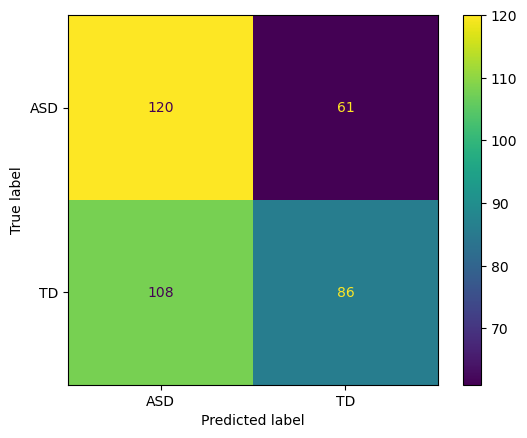

In [192]:
# Matrice de confusion

conf_matrix_corr_basc197_gnb = confusion_matrix(y_train_basc197, y_pred_corr_basc197_gnb)

disp = ConfusionMatrixDisplay(conf_matrix_corr_basc197_gnb, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [194]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_basc197_gnb = accuracy_score(y_train_basc197, y_pred_corr_basc197_gnb)
print("Accuracy : ", round(accuracy_corr_basc197_gnb,3))

# Calcul de la sensitivité
sensitivity_corr_basc197_gnb = conf_matrix_corr_basc197_gnb[1,1] / (conf_matrix_corr_basc197_gnb[1,0] + conf_matrix_corr_basc197_gnb[1,1])
print("Sensitivité : ", round(sensitivity_corr_basc197_gnb,3))

# Calcul de la spécificité
specificity_corr_basc197_gnb = conf_matrix_corr_basc197_gnb[0,0] / (conf_matrix_corr_basc197_gnb[0,0] + conf_matrix_corr_basc197_gnb[0,1])
print("Spécificité : ", round(specificity_corr_basc197_gnb,3))

# Calcul du classification report
class_report_corr_basc197_gnb = classification_report(y_train_basc197, y_pred_corr_basc197_gnb)
print("Classification Report :\n", class_report_corr_basc197_gnb)

Accuracy :  0.549
Sensitivité :  0.443
Spécificité :  0.663
Classification Report :
               precision    recall  f1-score   support

           1       0.53      0.66      0.59       181
           2       0.59      0.44      0.50       194

    accuracy                           0.55       375
   macro avg       0.56      0.55      0.55       375
weighted avg       0.56      0.55      0.54       375



##### Kernel SVM

In [196]:
# Optimisation hyperparamètres

param_grid_SVM = {'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf','sigmoid'],
    'degree' : [2,3,4,5]}

SVM_opt = SVC()
grid_search_SVM = GridSearchCV(SVM_opt, param_grid_SVM, cv=5, scoring='accuracy')
grid_search_SVM.fit(X_train_basc197, y_train_basc197)

print("Best parameters for Logistic Regression:", grid_search_SVM.best_params_)

Best parameters for Logistic Regression: {'C': 10, 'degree': 2, 'kernel': 'poly'}


In [199]:
#sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

# SVM : Cross-validation 10 folds
svm = SVC (kernel = 'poly', C=10, degree = 2)
cv = StratifiedKFold(n_splits=10)
y_pred_corr_basc197_svm = cross_val_predict(svm, X_train_basc197, y_train_basc197, cv = cv)

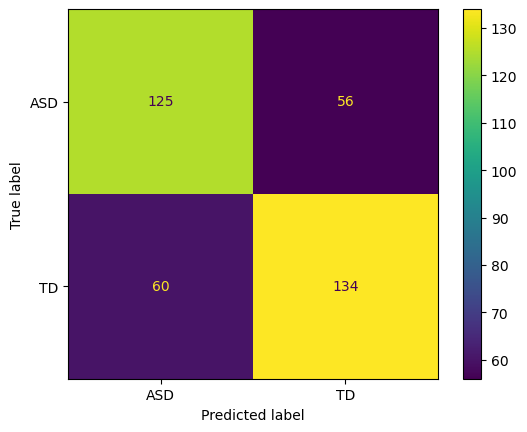

In [200]:
# Matrice de confusion

conf_matrix_corr_basc197_svm = confusion_matrix(y_train_basc197, y_pred_corr_basc197_svm)

disp = ConfusionMatrixDisplay(conf_matrix_corr_basc197_svm, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [201]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_basc197_svm = accuracy_score(y_train_basc197, y_pred_corr_basc197_svm)
print("Accuracy : ", round(accuracy_corr_basc197_svm,3))

# Calcul de la sensitivité
sensitivity_corr_basc197_svm = conf_matrix_corr_basc197_svm[1,1] / (conf_matrix_corr_basc197_svm[1,0] + conf_matrix_corr_basc197_svm[1,1])
print("Sensitivité : ", round(sensitivity_corr_basc197_svm,3))

# Calcul de la spécificité
specificity_corr_basc197_svm = conf_matrix_corr_basc197_svm[0,0] / (conf_matrix_corr_basc197_svm[0,0] + conf_matrix_corr_basc197_svm[0,1])
print("Spécificité : ", round(specificity_corr_basc197_svm,3))

# Calcul du classification report
class_report_corr_basc197_svm = classification_report(y_train_basc197, y_pred_corr_basc197_svm)
print("Classification Report :\n", class_report_corr_basc197_svm)

Accuracy :  0.691
Sensitivité :  0.691
Spécificité :  0.691
Classification Report :
               precision    recall  f1-score   support

           1       0.68      0.69      0.68       181
           2       0.71      0.69      0.70       194

    accuracy                           0.69       375
   macro avg       0.69      0.69      0.69       375
weighted avg       0.69      0.69      0.69       375



##### Random Forest

In [197]:
# Optimisation hyperparamètres

param_grid_RF = {'n_estimators': [100, 200, 300],
                'max_depth': [5,10,20],
                'criterion' : ['gini','entropy','log_loss']}

RF_opt = RandomForestClassifier()
grid_search_RF = GridSearchCV(RF_opt, param_grid_RF, cv=5, scoring='accuracy')
grid_search_RF.fit(X_train_basc197, y_train_basc197)

print("Best parameters for Logistic Regression:", grid_search_RF.best_params_)

Best parameters for Logistic Regression: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200}


In [206]:
#class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)

RF = RandomForestClassifier(n_estimators=200, criterion ='entropy', max_depth=5, random_state=123)
cv = StratifiedKFold(n_splits=10)
y_pred_corr_basc197_rf = cross_val_predict(RF, X_train_basc197, y_train_basc197, cv = cv)

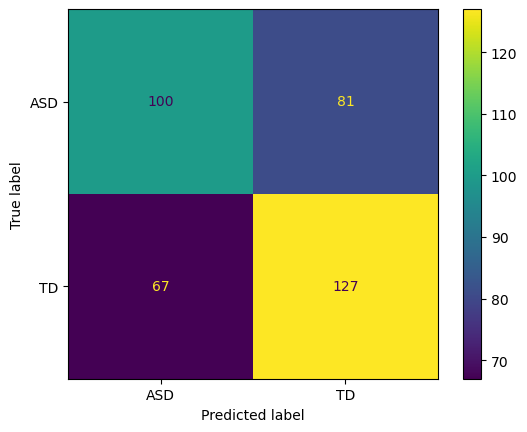

In [207]:
# Matrice de confusion

conf_matrix_corr_basc197_rf = confusion_matrix(y_train_basc197, y_pred_corr_basc197_rf)

disp = ConfusionMatrixDisplay(conf_matrix_corr_basc197_rf, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [208]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_corr_basc197_rf = accuracy_score(y_train_basc197, y_pred_corr_basc197_rf)
print("Accuracy : ", round(accuracy_corr_basc197_rf,3))

# Calcul de la sensitivité
sensitivity_corr_basc197_rf = conf_matrix_corr_basc197_rf[1,1] / (conf_matrix_corr_basc197_rf[1,0] + conf_matrix_corr_basc197_rf[1,1])
print("Sensitivité : ", round(sensitivity_corr_basc197_rf,3))

# Calcul de la spécificité
specificity_corr_basc197_rf = conf_matrix_corr_basc197_rf[0,0] / (conf_matrix_corr_basc197_rf[0,0] + conf_matrix_corr_basc197_rf[0,1])
print("Spécificité : ", round(specificity_corr_basc197_rf,3))

# Calcul du classification report
class_report_corr_basc197_rf = classification_report(y_train_basc197, y_pred_corr_basc197_rf)
print("Classification Report :\n", class_report_corr_basc197_rf)

Accuracy :  0.605
Sensitivité :  0.655
Spécificité :  0.552
Classification Report :
               precision    recall  f1-score   support

           1       0.60      0.55      0.57       181
           2       0.61      0.65      0.63       194

    accuracy                           0.61       375
   macro avg       0.60      0.60      0.60       375
weighted avg       0.60      0.61      0.60       375



#### Sélection du modèle

##### Tableau récapitulatif

In [218]:
# Define index and columns

arrays = [
    ['Harvard Oxford','Harvard Oxford','Harvard Oxford','Destrieux','Destrieux','Destrieux','Basc 197','Basc 197','Basc 197'],
    ['Accuracy', 'Sensitivity','Specificity','Accuracy', 'Sensitivity','Specificity','Accuracy', 'Sensitivity','Specificity']
]
multi_index = pd.MultiIndex.from_arrays(arrays, names=('', ''))

index = ["LR", "GNB","kSVM","RF"]

multi_index = pd.MultiIndex.from_arrays(arrays, names=('', ''))

# Data
data = [
    [accuracy_corr_ho_lr, sensitivity_corr_ho_lr, specificity_corr_ho_lr, accuracy_corr_destrieux_lr, sensitivity_corr_destrieux_lr, specificity_corr_destrieux_lr, accuracy_corr_basc197_lr, sensitivity_corr_basc197_lr, specificity_corr_basc197_lr],
    [accuracy_corr_ho_gnb, sensitivity_corr_ho_gnb, specificity_corr_ho_gnb, accuracy_corr_destrieux_gnb, sensitivity_corr_destrieux_gnb, specificity_corr_destrieux_gnb, accuracy_corr_basc197_gnb, sensitivity_corr_basc197_gnb, specificity_corr_basc197_gnb],
    [accuracy_corr_ho_svm, sensitivity_corr_ho_svm, specificity_corr_ho_svm, accuracy_corr_destrieux_svm, sensitivity_corr_destrieux_svm, specificity_corr_destrieux_svm, accuracy_corr_basc197_svm, sensitivity_corr_basc197_svm, specificity_corr_basc197_svm],
    [accuracy_corr_ho_rf, sensitivity_corr_ho_rf, specificity_corr_ho_rf, accuracy_corr_destrieux_rf, sensitivity_corr_destrieux_rf, specificity_corr_destrieux_rf, accuracy_corr_basc197_rf, sensitivity_corr_basc197_rf, specificity_corr_basc197_rf]
]

# Create the DataFrame
recap = pd.DataFrame(data, index = index, columns=multi_index)
recap.round(3)

Harvard Oxford                         Destrieux                          \
           Accuracy Sensitivity Specificity  Accuracy Sensitivity Specificity   
LR            0.629       0.727       0.525     0.680       0.732       0.624   
GNB           0.547       0.495       0.602     0.549       0.464       0.641   
kSVM          0.629       0.660       0.597     0.677       0.737       0.613   
RF            0.576       0.603       0.547     0.611       0.686       0.530   

     Basc 197                          
     Accuracy Sensitivity Specificity  
LR      0.685       0.701       0.669  
GNB     0.549       0.443       0.663  
kSVM    0.691       0.691       0.691  
RF      0.605       0.655       0.552

Meilleure spécificité : 69,1% - Atlas Basc197 et modèle kSVM
<br>
Meilleure sensibilité : 73,7% - Atlas Destrieux et modèle kSVM
<br>
Meilleur accuracy : 69,1% - Atlas Basc197 et modèle kSVM
<br>
Globalement, les modèles avec l'atlas Destrieux et l'atlas Basc197 avec les classifieurs LR et kSVM semblent intéressants. On sélectionne l'atlas basc197 et le modèle kSVM.

##### Courbes ROC

###### Atlas Destrieux - LR

C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

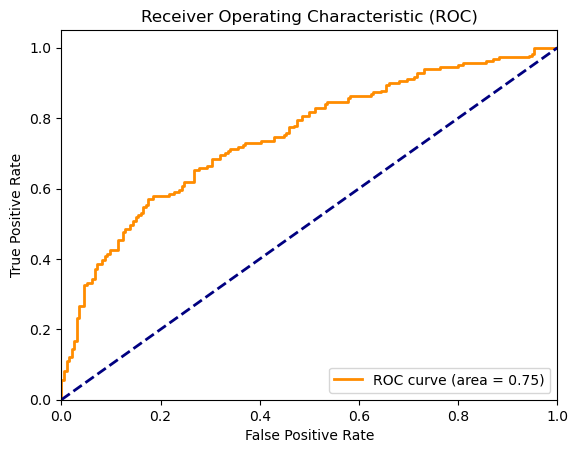

In [310]:
y_train_destrieux_binary = np.where(y_train_destrieux == 2, 0, 1)

# Définir le modèle SVM
LR_corr_destrieux_proba = LogisticRegression(C = 1, penalty='l2')
cv = StratifiedKFold(n_splits=10)
y_pred_prob_destrieux_lr = cross_val_predict(LR_corr_destrieux_proba, X_train_destrieux, y_train_destrieux_binary, cv=cv, method='predict_proba')[:, 1]

# Calculer les points de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_train_destrieux, y_pred_prob_destrieux_lr, pos_label=1)

# Calculer l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

###### Atlas Destrieux - SVM

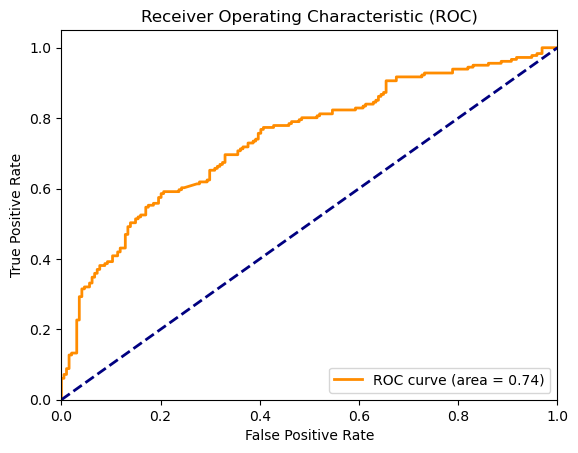

In [308]:
y_train_destrieux_binary = np.where(y_train_destrieux == 2, 0, 1)

# Définir le modèle SVM
SVM_corr_destrieux_proba = SVC(kernel = 'linear', C=0.1, probability = True)
cv = StratifiedKFold(n_splits=10)
y_pred_prob_destrieux_svm = cross_val_predict(SVM_corr_destrieux_proba, X_train_destrieux, y_train_destrieux_binary, cv=cv, method='predict_proba')[:, 1]

# Calculer les points de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_train_destrieux_binary, y_pred_prob_destrieux_svm, pos_label=1)

# Calculer l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

###### Atlas Basc197 - LR

C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\elodi\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

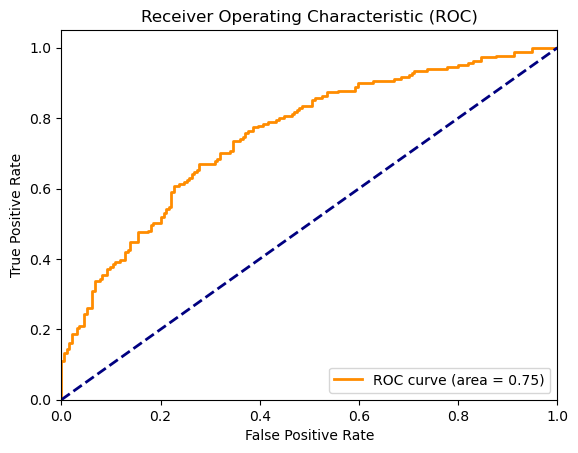

In [314]:
y_train_basc197_binary = np.where(y_train_basc197 == 2, 0, 1)

# Définir le modèle SVM
LR_corr_basc197_proba = LogisticRegression(C = 0.1, penalty='l2')
cv = StratifiedKFold(n_splits=10)
y_pred_prob_basc197_lr = cross_val_predict(LR_corr_basc197_proba, X_train_basc197, y_train_basc197_binary, cv=cv, method='predict_proba')[:, 1]

# Calculer les points de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_train_basc197, y_pred_prob_basc197_lr, pos_label=1)

# Calculer l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

###### Atlas Basc197 - SVM

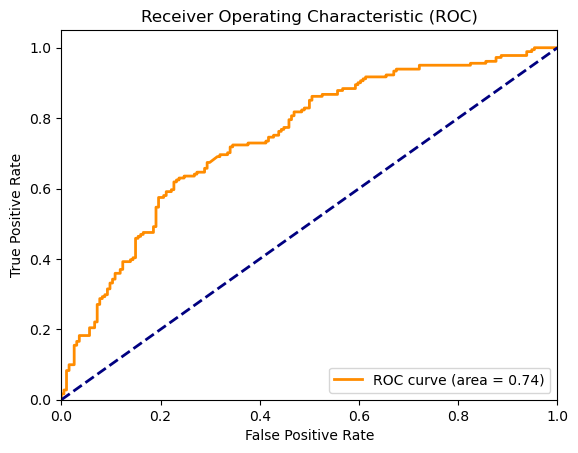

In [316]:
y_train_basc197_binary = np.where(y_train_basc197 == 2, 0, 1)

# Définir le modèle SVM
SVM_corr_basc197_proba = SVC(kernel = 'poly', C=10, degree = 2, probability = True)
cv = StratifiedKFold(n_splits=10)
y_pred_prob_basc197_svm = cross_val_predict(SVM_corr_basc197_proba, X_train_basc197, y_train_basc197_binary, cv=cv, method='predict_proba')[:, 1]

# Calculer les points de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_train_basc197_binary, y_pred_prob_basc197_svm, pos_label=1)

# Calculer l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

##### Essai sur la base de test : Atlas Basc197 et modèle kSVM

In [362]:
# SVM
svm = SVC (kernel = 'poly', C=10, degree = 2)
svm.fit(X_train_basc197, y_train_basc197)
y_pred = svm.predict(X_test_basc197)

In [363]:
"""
# LR
lr = LogisticRegression(C = 0.1, penalty='l2', max_iter = 200)
lr.fit(X_train_basc197, y_train_basc197)
y_pred = svm.predict(X_test_basc197)
"""

"\n# LR\nlr = LogisticRegression(C = 0.1, penalty='l2', max_iter = 200)\nlr.fit(X_train_basc197, y_train_basc197)\ny_pred = svm.predict(X_test_basc197)\n"

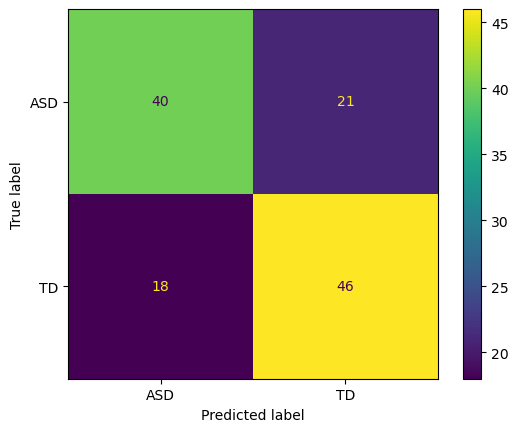

In [364]:
# Matrice de confusion

conf_matrix_test = confusion_matrix(y_test_basc197, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix_test, display_labels=["ASD","TD"])
disp.plot()
plt.show()

In [368]:
#Affichage des métriques

# Calcul de l'accuracy
accuracy_test = accuracy_score(y_test_basc197, y_pred)
print("Accuracy : ", round(accuracy_test,3))

# Calcul de la sensitivité
sensitivity_test = conf_matrix_test[1,1] / (conf_matrix_test[1,0] + conf_matrix_test[1,1])
print("Sensitivité : ", round(sensitivity_test,3))

# Calcul de la spécificité
specificity_test = conf_matrix_test[0,0] / (conf_matrix_test[0,0] + conf_matrix_test[0,1])
print("Spécificité : ", round(specificity_test,3))

# Calcul du classification report
class_test = classification_report(y_test_basc197, y_pred)
print("Classification Report :\n", class_test)

Accuracy :  0.688
Sensitivité :  0.719
Spécificité :  0.656
Classification Report :
               precision    recall  f1-score   support

           1       0.69      0.66      0.67        61
           2       0.69      0.72      0.70        64

    accuracy                           0.69       125
   macro avg       0.69      0.69      0.69       125
weighted avg       0.69      0.69      0.69       125

